<h1><center> Klasifikator </center></h1>

 <center>
    <h1><center>Microsoft malware classification</center></h1>
    <i>Klasifikacija zlonamjernog softvera</i> 
    <br><br>
    PRIRODOSLOVNO MATEMATIČKI FAKULTET - MATEMATIČKI ODSJEK <br>
    <b>Lipanj 2020.</b> 
    <br><br>
    <i>Stanišić Matea, Škrabo Petra, Terzanović Mateja, Tolja Margarita</i>  
</center>

***

Potrebno je u anaconda prompt-u instalirati xgboost s:<br>
<code>conda install -c anaconda py-xgboost</code>

### Priprema

In [1]:
# potrebni paketi
import numpy as np
from numpy import mean
from numpy import std
from numpy import loadtxt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import pyplot
from IPython.core.pylabtools import figsize
from collections import Counter
import random

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, log_loss, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import class_weight

In [2]:
# učitavanje svih značajki iz training skupa
features = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/merged_all_features.csv")

In [3]:
# učitavanje svih značajki iz training skupa
selected_features = pd.read_csv('selected_features_pca_train_cv2.csv')

In [4]:
selected_features = selected_features[list(selected_features.columns.values[:40])]

In [5]:
features.head()

,Id,Class,byte_1G_00,byte_1G_01,byte_1G_02,byte_1G_03,byte_1G_04,byte_1G_05,byte_1G_06,byte_1G_07,...,visualc,___security_cookie,assume,callvirtualalloc,exportedentry,hardware,hkey_current_user,hkey_local_machine,sp-analysisfailed,unableto
0,01kcPWA9K2BOxQeS5Rju,1,21091,1213,726,817,1257,625,550,523,...,0,0,0,0,0,0,0,0,0,0
1,04EjIdbPV5e1XroFOpiN,1,40030,1980,1226,1193,1971,1096,961,755,...,0,0,0,0,0,0,0,0,0,0
2,05EeG39MTRrI6VY21DPd,1,19419,955,693,656,832,463,370,510,...,0,0,0,0,0,0,0,0,0,0
3,05rJTUWYAKNegBk2wE8X,1,79568,6445,3143,2517,4982,1824,2125,2964,...,0,0,2,0,0,0,0,0,0,0
4,0AnoOZDNbPXIr2MRBSCJ,1,25791,1202,569,750,948,456,405,517,...,0,0,0,0,0,0,0,0,0,0


In [6]:
selected_features.head()

,Unnamed: 0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39
0,0,1.674513,-3.059634,-3.894463,3.289645,0.150883,-1.472087,-0.024001,0.238912,0.142270,...,0.151829,-0.514771,-0.084412,0.068432,0.073591,-0.089930,0.065747,0.070795,0.097492,0.132126
1,1,5.906251,1.554144,-2.833053,2.938874,0.805299,-3.636518,-0.402669,0.606742,1.311709,...,0.044457,-0.284964,-0.490513,0.064460,-0.248158,0.136959,0.022552,-0.000118,0.120075,0.210595
2,2,3.221069,-2.617408,-3.272275,2.647972,-0.069620,-4.990653,-0.219473,1.012171,0.981318,...,-0.125125,0.254433,-0.620814,0.336074,-0.126646,0.228267,0.082945,-0.081503,0.223538,0.441006
3,3,18.763987,17.527091,-0.863160,0.153083,-2.711496,-0.721077,-0.585667,6.261385,-0.466834,...,0.256698,-4.040179,-5.343816,2.850072,-0.593122,0.928882,-0.029514,0.358611,1.513826,2.976356
4,4,1.093519,-0.463915,-3.847778,1.583634,-2.348521,-0.712134,1.890559,-1.005999,0.738036,...,0.063579,-0.321892,-0.229663,-0.044180,0.407910,0.029281,0.068431,-0.061297,0.152343,0.453407


In [8]:
#razdvajanje kategorija značajki
one_gram_features = features.iloc[:,2:258]
metadata_bytes_features = features.iloc[:,258:260]
entropy_features = features.iloc[:,260:462]
image_features = features.iloc[:,462:514]
string_length_features = features.iloc[:,514:630]
metadata_asm_features = features.iloc[:,630:632]
symbols_features = features.iloc[:,632:639]
opcode_features = features.iloc[:,639:732]
reg_features = features.iloc[:,732:758]
section_features = features.iloc[:,758:782]
dd_features = features.iloc[:,782:806]
api_features = features.iloc[:,806:1600]
key_features = features.iloc[:,1600:1695]

In [7]:
#postavljanje seed-a za podjelu podataka na train i test
seed = 40

In [8]:
X=selected_features.iloc[:,1:187]
y=features.iloc[:,1]
X_train, X_test, y_train, y_test = train_test_split( X, features['Class'], test_size=0.3, random_state=seed)

### XGBClassifier

In [9]:
#početni parametri za XGBClassifier, kasnije ćemo ih promijeniti
params = {}
params['n_estimators'] = 50
params['learning_rate'] = 0.5
params['max_depth'] = 5
params['colsample_bytree'] = 0.5
params['objective'] = 'multi:softprob'
params['eval_metric'] = 'mlogloss'

In [10]:
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.set_params(**params)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eval_metric='mlogloss',
              gamma=0, learning_rate=0.5, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=50, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [28]:
def xgboost_test(model, X_test, y_test):
    
    preds = model.predict_proba(X_test)

    best_preds = model.predict(X_test)

    score_log = log_loss(y_test,preds,eps=1e-15)
    score_acc = accuracy_score(y_test, best_preds)

    print('Logloss:' + str(score_log))
    print('Accuracy:' + str(score_acc))

    make_and_plot_confusion_matrix(y_test,best_preds)


###  confusion matrix

In [12]:
#funkcija koja računa i crta matricu konfuzije
def make_and_plot_confusion_matrix(y_test, best_preds):
    names = ['class 1', 'class 2','class 3', 'class 4', 'class 5','class 6', 'class 7', 'class 8', 'class 9']
    cm = confusion_matrix(y_test, best_preds)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    norm_conf = []
    for i in cm:
        a = 0
        tmp_arr = []
        a = sum(i, 0)
        for j in i:
            tmp_arr.append(float(j)/float(a))
        norm_conf.append(tmp_arr)

    fig = plt.figure(figsize(10, 10))
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    
    res = ax.imshow(np.array(norm_conf), cmap=plt.cm.Blues, interpolation='nearest')

    width = len(cm)
    height = len(cm[0])

    for x in range(width):
        for y in range(height):
            ax.annotate(str(format(round(cm[x][y], 2))), xy=(y, x), horizontalalignment='center', verticalalignment='center')
    plt.title('Confusion matrix')
    cb = fig.colorbar(res)
    plt.xticks(range(width), names)
    plt.yticks(range(height), names)

### iteracije za XGBClassifier

In [33]:
eval_set = [(X_train, y_train), (X_test, y_test)]

model = xgb.XGBClassifier(n_estimators=1000)
#params['n_estimators'] = 300
#model.set_params(**params)
model.fit(X_train, y_train, early_stopping_rounds=15, eval_metric=["merror", "mlogloss"], eval_set=eval_set, verbose=True)



[0]	validation_0-merror:0.087825	validation_0-mlogloss:1.84827	validation_1-merror:0.097823	validation_1-mlogloss:1.84879
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 15 rounds.
[1]	validation_0-merror:0.083224	validation_0-mlogloss:1.61444	validation_1-merror:0.09353	validation_1-mlogloss:1.61668
[2]	validation_0-merror:0.068367	validation_0-mlogloss:1.43304	validation_1-merror:0.081263	validation_1-mlogloss:1.43784
[3]	validation_0-merror:0.059164	validation_0-mlogloss:1.28587	validation_1-merror:0.070531	validation_1-mlogloss:1.29197
[4]	validation_0-merror:0.053379	validation_0-mlogloss:1.16039	validation_1-merror:0.065011	validation_1-mlogloss:1.16775
[5]	validation_0-merror:0.056403	validation_0-mlogloss:1.05204	validation_1-merror:0.066544	validation_1-mlogloss:1.06081
[6]	validation_0-merror:0.054036	validation_0-mlogloss:0.958423	validation_1-merror:0.060718	validatio

[65]	validation_0-merror:0.01157	validation_0-mlogloss:0.061614	validation_1-merror:0.026066	validation_1-mlogloss:0.098858
[66]	validation_0-merror:0.011044	validation_0-mlogloss:0.060119	validation_1-merror:0.026066	validation_1-mlogloss:0.097427
[67]	validation_0-merror:0.010912	validation_0-mlogloss:0.058633	validation_1-merror:0.025452	validation_1-mlogloss:0.096211
[68]	validation_0-merror:0.009992	validation_0-mlogloss:0.057044	validation_1-merror:0.024532	validation_1-mlogloss:0.094635
[69]	validation_0-merror:0.009729	validation_0-mlogloss:0.05571	validation_1-merror:0.024532	validation_1-mlogloss:0.093424
[70]	validation_0-merror:0.009466	validation_0-mlogloss:0.054242	validation_1-merror:0.024532	validation_1-mlogloss:0.092096
[71]	validation_0-merror:0.009466	validation_0-mlogloss:0.052994	validation_1-merror:0.024532	validation_1-mlogloss:0.091054
[72]	validation_0-merror:0.009203	validation_0-mlogloss:0.051836	validation_1-merror:0.024532	validation_1-mlogloss:0.090093
[7

[131]	validation_0-merror:0.000789	validation_0-mlogloss:0.016656	validation_1-merror:0.017786	validation_1-mlogloss:0.061314
[132]	validation_0-merror:0.000789	validation_0-mlogloss:0.016375	validation_1-merror:0.017786	validation_1-mlogloss:0.061074
[133]	validation_0-merror:0.000657	validation_0-mlogloss:0.016062	validation_1-merror:0.017786	validation_1-mlogloss:0.060819
[134]	validation_0-merror:0.000526	validation_0-mlogloss:0.015761	validation_1-merror:0.017786	validation_1-mlogloss:0.060543
[135]	validation_0-merror:0.000394	validation_0-mlogloss:0.015542	validation_1-merror:0.017786	validation_1-mlogloss:0.060462
[136]	validation_0-merror:0.000394	validation_0-mlogloss:0.015282	validation_1-merror:0.017786	validation_1-mlogloss:0.060086
[137]	validation_0-merror:0.000394	validation_0-mlogloss:0.015072	validation_1-merror:0.017786	validation_1-mlogloss:0.059913
[138]	validation_0-merror:0.000394	validation_0-mlogloss:0.014857	validation_1-merror:0.017786	validation_1-mlogloss:0

[199]	validation_0-merror:0	validation_0-mlogloss:0.006272	validation_1-merror:0.015946	validation_1-mlogloss:0.052452
[200]	validation_0-merror:0	validation_0-mlogloss:0.006207	validation_1-merror:0.015946	validation_1-mlogloss:0.052429
[201]	validation_0-merror:0	validation_0-mlogloss:0.006137	validation_1-merror:0.015946	validation_1-mlogloss:0.052369
[202]	validation_0-merror:0	validation_0-mlogloss:0.006063	validation_1-merror:0.015946	validation_1-mlogloss:0.052303
[203]	validation_0-merror:0	validation_0-mlogloss:0.005979	validation_1-merror:0.015639	validation_1-mlogloss:0.052171
[204]	validation_0-merror:0	validation_0-mlogloss:0.005905	validation_1-merror:0.015639	validation_1-mlogloss:0.052022
[205]	validation_0-merror:0	validation_0-mlogloss:0.005826	validation_1-merror:0.015639	validation_1-mlogloss:0.051875
[206]	validation_0-merror:0	validation_0-mlogloss:0.005759	validation_1-merror:0.015026	validation_1-mlogloss:0.051751
[207]	validation_0-merror:0	validation_0-mloglos

[268]	validation_0-merror:0	validation_0-mlogloss:0.00304	validation_1-merror:0.014719	validation_1-mlogloss:0.049174
[269]	validation_0-merror:0	validation_0-mlogloss:0.003012	validation_1-merror:0.014719	validation_1-mlogloss:0.049101
[270]	validation_0-merror:0	validation_0-mlogloss:0.002989	validation_1-merror:0.014719	validation_1-mlogloss:0.049075
[271]	validation_0-merror:0	validation_0-mlogloss:0.002962	validation_1-merror:0.014719	validation_1-mlogloss:0.049008
[272]	validation_0-merror:0	validation_0-mlogloss:0.002932	validation_1-merror:0.014719	validation_1-mlogloss:0.048987
[273]	validation_0-merror:0	validation_0-mlogloss:0.002908	validation_1-merror:0.014719	validation_1-mlogloss:0.048968
[274]	validation_0-merror:0	validation_0-mlogloss:0.002887	validation_1-merror:0.014719	validation_1-mlogloss:0.048976
[275]	validation_0-merror:0	validation_0-mlogloss:0.002862	validation_1-merror:0.014719	validation_1-mlogloss:0.048938
[276]	validation_0-merror:0	validation_0-mlogloss

[338]	validation_0-merror:0	validation_0-mlogloss:0.001889	validation_1-merror:0.015026	validation_1-mlogloss:0.048343
[339]	validation_0-merror:0	validation_0-mlogloss:0.001878	validation_1-merror:0.015026	validation_1-mlogloss:0.04832
[340]	validation_0-merror:0	validation_0-mlogloss:0.00187	validation_1-merror:0.015026	validation_1-mlogloss:0.048252
[341]	validation_0-merror:0	validation_0-mlogloss:0.001859	validation_1-merror:0.015026	validation_1-mlogloss:0.048201
[342]	validation_0-merror:0	validation_0-mlogloss:0.001851	validation_1-merror:0.015026	validation_1-mlogloss:0.048198
[343]	validation_0-merror:0	validation_0-mlogloss:0.00184	validation_1-merror:0.015026	validation_1-mlogloss:0.048169
[344]	validation_0-merror:0	validation_0-mlogloss:0.001833	validation_1-merror:0.015026	validation_1-mlogloss:0.048179
[345]	validation_0-merror:0	validation_0-mlogloss:0.001824	validation_1-merror:0.015026	validation_1-mlogloss:0.048178
[346]	validation_0-merror:0	validation_0-mlogloss:0

[408]	validation_0-merror:0	validation_0-mlogloss:0.001408	validation_1-merror:0.015026	validation_1-mlogloss:0.047509
[409]	validation_0-merror:0	validation_0-mlogloss:0.001403	validation_1-merror:0.015026	validation_1-mlogloss:0.04746
[410]	validation_0-merror:0	validation_0-mlogloss:0.001399	validation_1-merror:0.015026	validation_1-mlogloss:0.047446
[411]	validation_0-merror:0	validation_0-mlogloss:0.001393	validation_1-merror:0.014413	validation_1-mlogloss:0.047431
[412]	validation_0-merror:0	validation_0-mlogloss:0.001389	validation_1-merror:0.014413	validation_1-mlogloss:0.047414
[413]	validation_0-merror:0	validation_0-mlogloss:0.001383	validation_1-merror:0.014719	validation_1-mlogloss:0.047417
[414]	validation_0-merror:0	validation_0-mlogloss:0.001379	validation_1-merror:0.014719	validation_1-mlogloss:0.047418
[415]	validation_0-merror:0	validation_0-mlogloss:0.001374	validation_1-merror:0.014719	validation_1-mlogloss:0.047389
[416]	validation_0-merror:0	validation_0-mlogloss

[477]	validation_0-merror:0	validation_0-mlogloss:0.001144	validation_1-merror:0.014106	validation_1-mlogloss:0.046686
[478]	validation_0-merror:0	validation_0-mlogloss:0.001141	validation_1-merror:0.013799	validation_1-mlogloss:0.046653
[479]	validation_0-merror:0	validation_0-mlogloss:0.001138	validation_1-merror:0.013799	validation_1-mlogloss:0.046622
[480]	validation_0-merror:0	validation_0-mlogloss:0.001135	validation_1-merror:0.014106	validation_1-mlogloss:0.046591
[481]	validation_0-merror:0	validation_0-mlogloss:0.001133	validation_1-merror:0.014106	validation_1-mlogloss:0.046582
[482]	validation_0-merror:0	validation_0-mlogloss:0.00113	validation_1-merror:0.014106	validation_1-mlogloss:0.046593
[483]	validation_0-merror:0	validation_0-mlogloss:0.001128	validation_1-merror:0.014106	validation_1-mlogloss:0.046618
[484]	validation_0-merror:0	validation_0-mlogloss:0.001125	validation_1-merror:0.014106	validation_1-mlogloss:0.046584
[485]	validation_0-merror:0	validation_0-mlogloss

[546]	validation_0-merror:0	validation_0-mlogloss:0.000987	validation_1-merror:0.013799	validation_1-mlogloss:0.04632
[547]	validation_0-merror:0	validation_0-mlogloss:0.000985	validation_1-merror:0.013799	validation_1-mlogloss:0.046337
[548]	validation_0-merror:0	validation_0-mlogloss:0.000984	validation_1-merror:0.013799	validation_1-mlogloss:0.046327
[549]	validation_0-merror:0	validation_0-mlogloss:0.000982	validation_1-merror:0.013799	validation_1-mlogloss:0.04633
[550]	validation_0-merror:0	validation_0-mlogloss:0.00098	validation_1-merror:0.013799	validation_1-mlogloss:0.046309
[551]	validation_0-merror:0	validation_0-mlogloss:0.000979	validation_1-merror:0.013799	validation_1-mlogloss:0.046298
[552]	validation_0-merror:0	validation_0-mlogloss:0.000977	validation_1-merror:0.013799	validation_1-mlogloss:0.046297
[553]	validation_0-merror:0	validation_0-mlogloss:0.000975	validation_1-merror:0.013799	validation_1-mlogloss:0.046324
[554]	validation_0-merror:0	validation_0-mlogloss:0

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

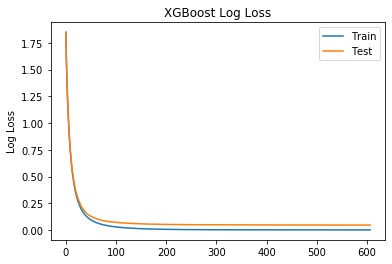

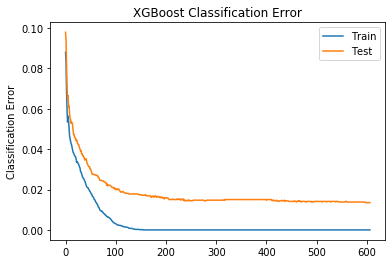

In [34]:
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

uzet čemo broj iteracija jednak 20 jer nakon toga nema značajnijeg pada a dobit ćemo na brzini

In [43]:
params['n_estimators'] = 200

Mislim da sada stvarno mogu zaključiti da su gornja dva pristupa jednaka. Mnogo puta su mi ispadali dosta drugačiji rezultati,
ali sam zaključila da te to zbog razlike u parametrima. Neki se drugačije zovu, neki se koriste skroz drugačije. Za sada nek 
stoje oba pristupa pa ćemo vidjeti koji je najzgodniji za korištenje na kraju. Ne znam više gdje se labele trebaju smanjit 
za 1, a gdje ne. Isprike što nisam konzistentna.

### testiranje parametara

In [44]:
model_XGB = xgb.XGBClassifier(n_estimators =200, objective= 'multi:softprob')

In [45]:
max_depth_range = list(range(3,10))

learning_rate_range = list(range(1, 5))
learning_rate_range = [x / 10 for x in learning_rate_range]
#learning_rate_range.append(0.01)

colsample_bytree_range = list(range(5, 10))
colsample_bytree_range = [x / 10 for x in colsample_bytree_range]

#gamma_range = list()
#gamma_range.append(0)
#gamma_range.append(1)
#gamma_range.append(5)

param_ranges = dict(learning_rate = learning_rate_range,
                      max_depth=max_depth_range,
                     colsample_bytree=colsample_bytree_range)

In [46]:
# koristimo RandomizedSearchCV za testiranje parametara
rand_search = RandomizedSearchCV(model_XGB, param_ranges, cv=5, scoring='accuracy', n_iter=20, 
                                 random_state=5, return_train_score=False, n_jobs=-1)
rand_search.fit(X, y)

KeyboardInterrupt: 

In [ ]:
pd.set_option('display.max_colwidth', None)
pd.DataFrame(rand_search.cv_results_)[['mean_test_score', 'params']]


In [ ]:
# dohvaćanje najboljih parametara
print(rand_search.best_score_)
print(rand_search.best_params_)
param3=rand_search.best_params_
param3['n_estimators'] = 200
param3['objective'] = 'multi:softprob'

### isto samo s neg_log_loss

In [47]:
# koristimo RandomizedSearchCV za testiranje parametara
# neg_log_los je bolji što je veći(suprotno od logloss). Ovdje se ne može koristiti logloss
rand_search = RandomizedSearchCV(model_XGB, param_ranges, cv=5, scoring='neg_log_loss', n_iter=20, 
                                 random_state=5, return_train_score=False, n_jobs=-1)
rand_search.fit(X, y)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=200,
                                           n_jobs=1, nthread=None,
                                           objective='multi:softprob',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='dep

In [48]:
pd.set_option('display.max_colwidth', None)
pd.DataFrame(rand_search.cv_results_)[['mean_test_score', 'params']]


,mean_test_score,params
0,-0.052368,"{'max_depth': 4, 'learning_rate': 0.3, 'colsample_bytree': 0.6}"
1,-0.052364,"{'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.7}"
2,-0.053532,"{'max_depth': 9, 'learning_rate': 0.3, 'colsample_bytree': 0.6}"
3,-0.054416,"{'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.9}"
4,-0.053815,"{'max_depth': 8, 'learning_rate': 0.4, 'colsample_bytree': 0.6}"
5,-0.052424,"{'max_depth': 6, 'learning_rate': 0.2, 'colsample_bytree': 0.7}"
6,-0.053484,"{'max_depth': 6, 'learning_rate': 0.2, 'colsample_bytree': 0.8}"
7,-0.052324,"{'max_depth': 5, 'learning_rate': 0.4, 'colsample_bytree': 0.5}"
8,-0.052705,"{'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.8}"
9,-0.052984,"{'max_depth': 7, 'learning_rate': 0.4, 'colsample_bytree': 0.5}"


In [49]:
# dohvaćanje najboljih parametara
print(rand_search.best_score_)
print(rand_search.best_params_)
param4=rand_search.best_params_
param4['n_estimators'] = 200 
param4['objective'] = 'multi:softprob'

-0.050298044719726806
{'max_depth': 8, 'learning_rate': 0.2, 'colsample_bytree': 0.5}


Dobili smo jednak rezultat za accuracy i za logloss tako da ćemo uzeti te parametre

In [13]:
params['learning_rate'] = 0.2
params['max_depth'] = 8
params['colsample_bytree'] = 0.5

In [51]:
params

{'n_estimators': 200,
 'learning_rate': 0.2,
 'max_depth': 8,
 'colsample_bytree': 0.5,
 'objective': 'multi:softprob',
 'eval_metric': 'mlogloss'}

In [52]:
model = xgb.XGBClassifier(**params)
#params['n_estimators'] = 300
#model.set_params(**params)
model.fit(X_train, y_train, early_stopping_rounds=15, eval_metric=["merror", "mlogloss"], eval_set=eval_set, verbose=True)

[0]	validation_0-merror:0.027084	validation_0-mlogloss:1.43419	validation_1-merror:0.055198	validation_1-mlogloss:1.45797
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 15 rounds.
[1]	validation_0-merror:0.015514	validation_0-mlogloss:1.08832	validation_1-merror:0.035879	validation_1-mlogloss:1.1213
[2]	validation_0-merror:0.010781	validation_0-mlogloss:0.856848	validation_1-merror:0.030052	validation_1-mlogloss:0.896085
[3]	validation_0-merror:0.008151	validation_0-mlogloss:0.689525	validation_1-merror:0.026986	validation_1-mlogloss:0.732474
[4]	validation_0-merror:0.006574	validation_0-mlogloss:0.559209	validation_1-merror:0.024839	validation_1-mlogloss:0.605834
[5]	validation_0-merror:0.005653	validation_0-mlogloss:0.459049	validation_1-merror:0.025452	validation_1-mlogloss:0.509006
[6]	validation_0-merror:0.004602	validation_0-mlogloss:0.378173	validation_1-merror:0.024226	v

[68]	validation_0-merror:0	validation_0-mlogloss:0.002097	validation_1-merror:0.015026	validation_1-mlogloss:0.049606
[69]	validation_0-merror:0	validation_0-mlogloss:0.00206	validation_1-merror:0.015026	validation_1-mlogloss:0.049465
[70]	validation_0-merror:0	validation_0-mlogloss:0.002025	validation_1-merror:0.015026	validation_1-mlogloss:0.049487
[71]	validation_0-merror:0	validation_0-mlogloss:0.001992	validation_1-merror:0.015026	validation_1-mlogloss:0.049365
[72]	validation_0-merror:0	validation_0-mlogloss:0.001957	validation_1-merror:0.015026	validation_1-mlogloss:0.049365
[73]	validation_0-merror:0	validation_0-mlogloss:0.001923	validation_1-merror:0.015026	validation_1-mlogloss:0.049379
[74]	validation_0-merror:0	validation_0-mlogloss:0.001893	validation_1-merror:0.015026	validation_1-mlogloss:0.049353
[75]	validation_0-merror:0	validation_0-mlogloss:0.001865	validation_1-merror:0.015026	validation_1-mlogloss:0.049297
[76]	validation_0-merror:0	validation_0-mlogloss:0.001834

[138]	validation_0-merror:0	validation_0-mlogloss:0.001103	validation_1-merror:0.015333	validation_1-mlogloss:0.048314
[139]	validation_0-merror:0	validation_0-mlogloss:0.001098	validation_1-merror:0.015333	validation_1-mlogloss:0.048252
[140]	validation_0-merror:0	validation_0-mlogloss:0.001093	validation_1-merror:0.015333	validation_1-mlogloss:0.04822
[141]	validation_0-merror:0	validation_0-mlogloss:0.001088	validation_1-merror:0.015333	validation_1-mlogloss:0.048144
[142]	validation_0-merror:0	validation_0-mlogloss:0.001083	validation_1-merror:0.015333	validation_1-mlogloss:0.048179
[143]	validation_0-merror:0	validation_0-mlogloss:0.001078	validation_1-merror:0.015333	validation_1-mlogloss:0.048201
[144]	validation_0-merror:0	validation_0-mlogloss:0.001074	validation_1-merror:0.015333	validation_1-mlogloss:0.048225
[145]	validation_0-merror:0	validation_0-mlogloss:0.00107	validation_1-merror:0.015333	validation_1-mlogloss:0.048219
[146]	validation_0-merror:0	validation_0-mlogloss:

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eval_metric='mlogloss',
              gamma=0, learning_rate=0.2, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [14]:
params['n_estimators'] = 141

<br>
<br>

# XGboost proveden na svim značajkama

Logloss:0.01212141834445314
Accuracy:0.9957068383931309


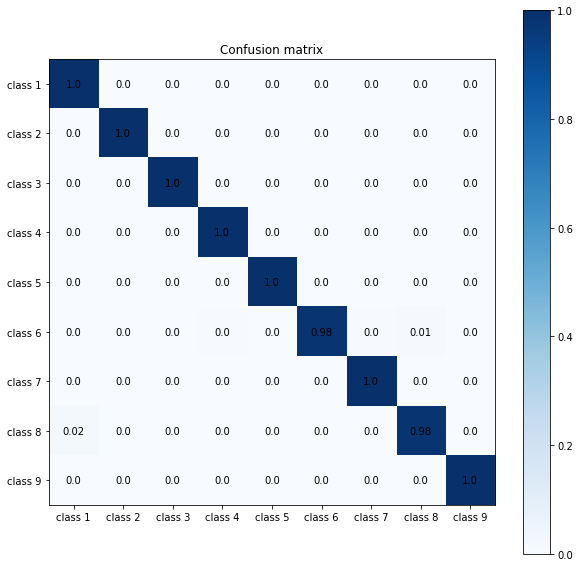

In [54]:
X_all=features.iloc[:,2:1695]
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split( X_all, features['Class'], test_size=0.3, random_state=seed)
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.set_params(**params)
xgb_classifier.fit(X_train_all, y_train_all)
xgboost_test(xgb_classifier,X_test_all,y_test_all)


### Dalje radimo na selektiranim značajkama <br>

Logloss:0.2265664710109492
Accuracy:0.9846672799754677


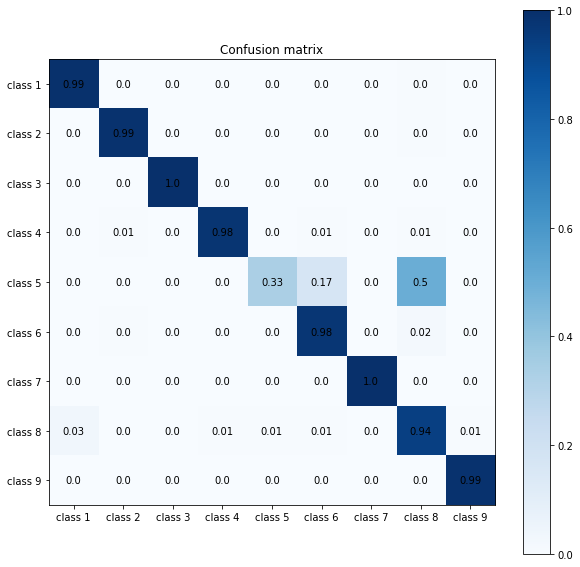

In [27]:
#xgboost na selektiranim značajkama
X_train, X_test, y_train, y_test = train_test_split( X, features['Class'], test_size=0.3, random_state=seed)
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.set_params(**params)
xgb_classifier.fit(X_train, y_train)
xgboost_test(xgb_classifier,X_test,y_test)

## Pokušaji rješavanja nebalasiranosti podataka

### dodavanje težina u XGboost

Logloss:0.04371702259193001
Accuracy:0.9871205151793928


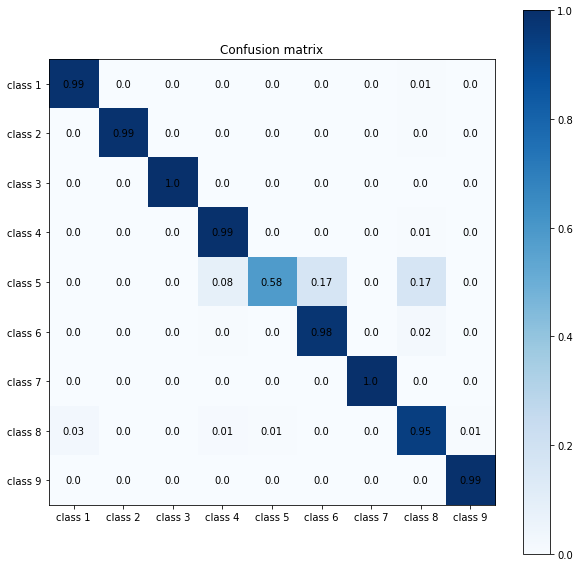

In [22]:
#xgboost sa dodanim težinama
X_train, X_test, y_train, y_test = train_test_split( X, features['Class'], test_size=0.3, random_state=seed)

class_weights = list(class_weight.compute_class_weight('balanced', np.unique(y_train),y_train))
w_array = np.ones(y_train.shape[0], dtype = 'float')
for i, val in enumerate(y_train):
    w_array[i] = class_weights[val-1]

xgb_classifier = xgb.XGBClassifier()
xgb_classifier.set_params(**params)
xgb_classifier.fit(X_train, y_train, sample_weight=w_array)

xgboost_test(xgb_classifier,X_test,y_test)

### oversampling

[(1, 2036), (2, 2036), (3, 2036), (4, 2036), (5, 2036), (6, 2036), (7, 2036), (8, 2036), (9, 2036)]
Logloss:0.04555224767021493
Accuracy:0.9868138607789022


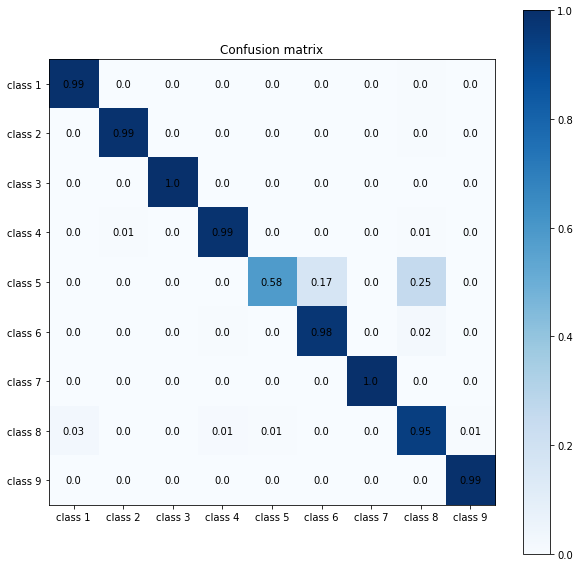

In [58]:
#RandomOverSampler
X_train, X_test, y_train, y_test = train_test_split( X, features['Class'], test_size=0.3, random_state=seed)
ros = RandomOverSampler(random_state=0)
X_train, y_train = ros.fit_resample(X_train, y_train)
print(sorted(Counter(y_train).items()))
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.set_params(**params)
xgb_classifier.fit(X_train, y_train)
xgboost_test(xgb_classifier,X_test,y_test)

[(1, 2036), (2, 2036), (3, 2036), (4, 2036), (5, 2036), (6, 2036), (7, 2036), (8, 2036), (9, 2036)]
Logloss:0.04055097794157283
Accuracy:0.9880404783808647


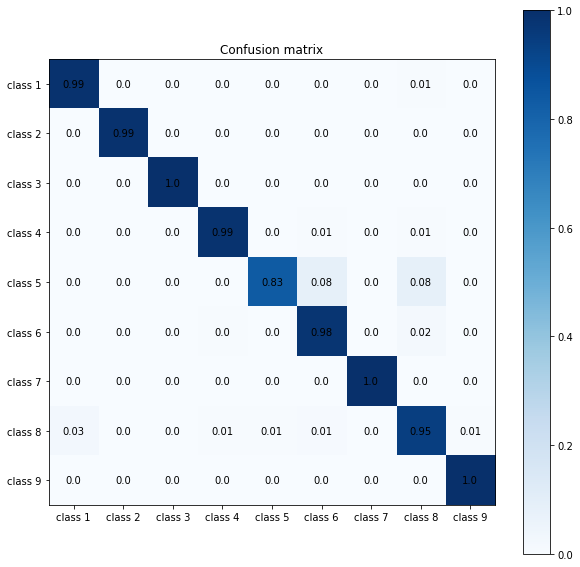

In [59]:
#SMOTE
X_train, X_test, y_train, y_test = train_test_split( X, features['Class'], test_size=0.3, random_state=seed)
X_train, y_train = SMOTE().fit_resample(X_train, y_train)
print(sorted(Counter(y_train).items()))
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.set_params(**params)
xgb_classifier.fit(X_train, y_train)
xgboost_test(xgb_classifier,X_test,y_test)


[(1, 2036), (2, 2036), (3, 2036), (4, 2036), (5, 2036), (6, 2036), (7, 2036), (8, 2036), (9, 2036)]
Logloss:0.040362894546122755
Accuracy:0.9880404783808647


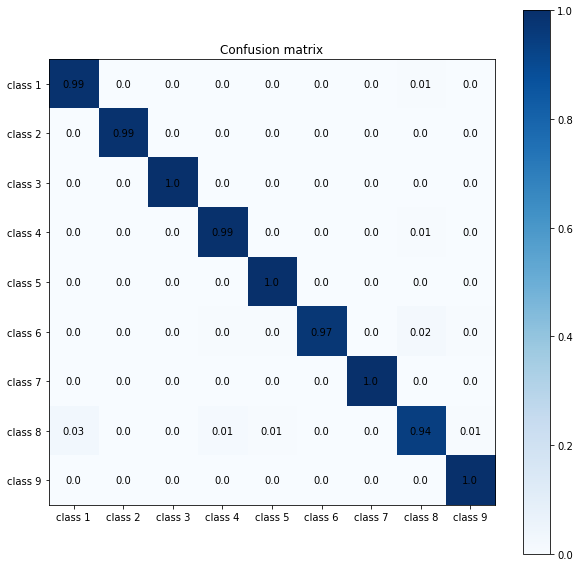

In [23]:
#SMOTE+težine
X_train, X_test, y_train, y_test = train_test_split( X, features['Class'], test_size=0.3, random_state=seed)

class_weights = list(class_weight.compute_class_weight('balanced', np.unique(y_train),y_train))
    
X_train, y_train = SMOTE().fit_resample(X_train, y_train)
print(sorted(Counter(y_train).items()))

w_array = np.ones(y_train.shape[0], dtype = 'float')
for i, val in enumerate(y_train):
    w_array[i] = class_weights[val-1]
    
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.set_params(**params)
xgb_classifier.fit(X_train, y_train, sample_weight=w_array)

xgboost_test(xgb_classifier,X_test,y_test)

[(1, 2021), (2, 2034), (3, 2036), (4, 2031), (5, 2031), (6, 2026), (7, 2040), (8, 2028), (9, 2025)]
Logloss:0.03565455188992738
Accuracy:0.989573750383318


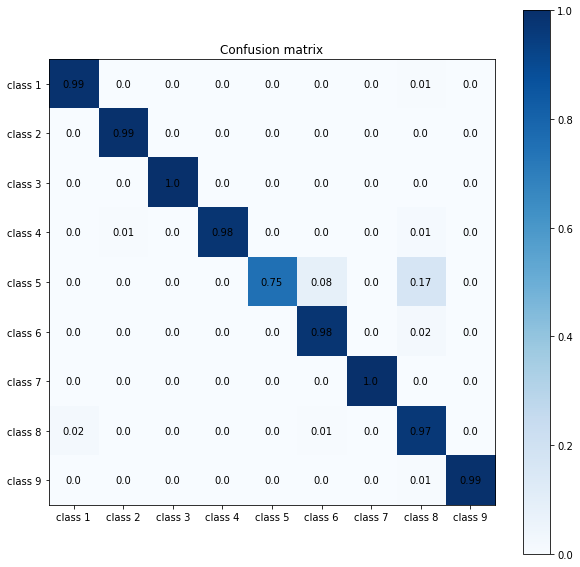

In [16]:
#ADASYN
X_train, X_test, y_train, y_test = train_test_split( X, features['Class'], test_size=0.3, random_state=seed)
X_train, y_train = ADASYN().fit_resample(X_train, y_train)
print(sorted(Counter(y_train).items()))
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.set_params(**params)
xgb_classifier.fit(X_train, y_train)
xgboost_test(xgb_classifier,X_test,y_test)

[(1, 2021), (2, 2034), (3, 2036), (4, 2031), (5, 2031), (6, 2026), (7, 2040), (8, 2028), (9, 2025)]
Logloss:0.03584118436082368
Accuracy:0.9898804047838087


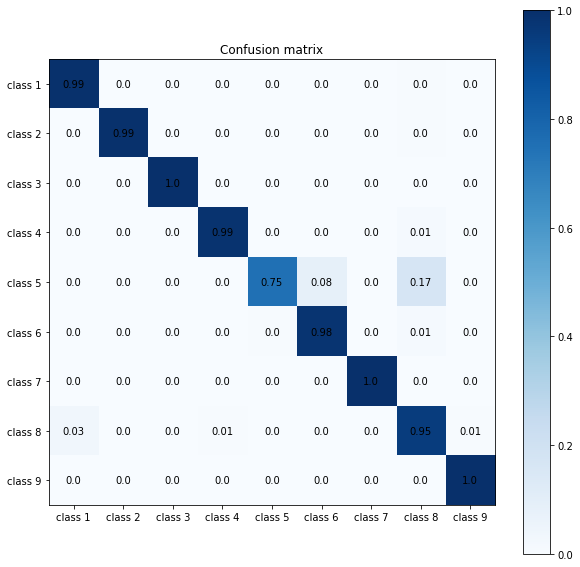

In [24]:
#ADASYN+težine
X_train, X_test, y_train, y_test = train_test_split( X, features['Class'], test_size=0.3, random_state=seed)

class_weights = list(class_weight.compute_class_weight('balanced', np.unique(y_train),y_train))

X_train, y_train = ADASYN().fit_resample(X_train, y_train)
print(sorted(Counter(y_train).items()))

w_array = np.ones(y_train.shape[0], dtype = 'float')
for i, val in enumerate(y_train):
    w_array[i] = class_weights[val-1]

xgb_classifier = xgb.XGBClassifier()
xgb_classifier.set_params(**params)
xgb_classifier.fit(X_train, y_train, sample_weight=w_array)

xgboost_test(xgb_classifier,X_test,y_test)

### undersample

[(1, 1084), (2, 1753), (3, 30), (4, 332), (5, 30), (6, 506), (7, 278), (8, 881), (9, 706)]
Logloss:0.055091833402209744
Accuracy:0.983440662373505


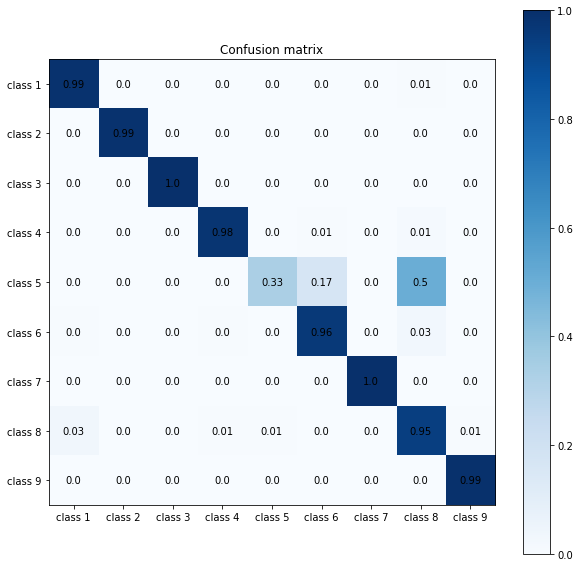

In [18]:
#RandomUnderSampler
X_train, X_test, y_train, y_test = train_test_split( X, features['Class'], test_size=0.3, random_state=seed)
undersample = RandomUnderSampler(sampling_strategy='majority')
X_train, y_train = undersample.fit_resample(X_train, y_train)
print(sorted(Counter(y_train).items()))

xgb_classifier = xgb.XGBClassifier()
xgb_classifier.set_params(**params)
xgb_classifier.fit(X_train, y_train)
xgboost_test(xgb_classifier,X_test,y_test)

## bagging

Logloss:0.05289978763032699
Accuracy:0.985280588776449


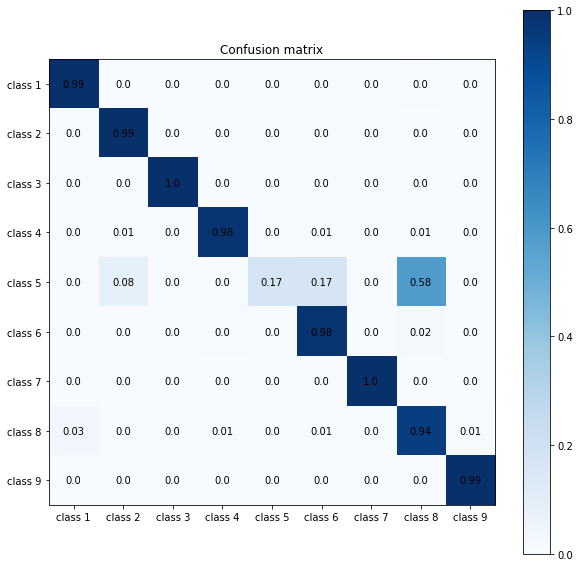

In [20]:
#BaggingClassifier iz sklearn-a, ali čini mi se da moramo koristit XGBClassifier()
X_train, X_test, y_train, y_test = train_test_split( X, features['Class'], test_size=0.3, random_state=seed)
exgb_classifier = xgb.XGBClassifier()
exgb_classifier.set_params(**params)

model = BaggingClassifier(base_estimator=exgb_classifier, n_estimators=10, random_state=seed)
model.fit(X_train, y_train)

xgboost_test(model,X_test,y_test)

[(1, 2021), (2, 2034), (3, 2036), (4, 2031), (5, 2031), (6, 2026), (7, 2040), (8, 2028), (9, 2025)]
Logloss:0.03360313600760857
Accuracy:0.9898804047838087


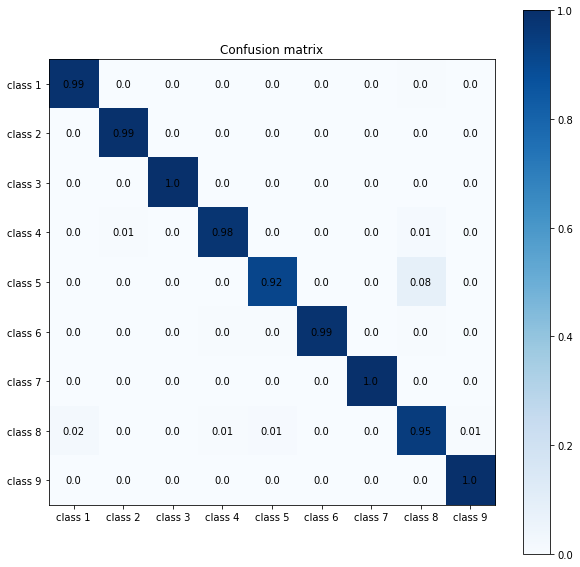

In [25]:
#Bagging + adasyn + weights
X_train, X_test, y_train, y_test = train_test_split( X, features['Class'], test_size=0.3, random_state=seed)
class_weights = list(class_weight.compute_class_weight('balanced', np.unique(y_train),y_train))
X_train, y_train = ADASYN().fit_resample(X_train, y_train)
print(sorted(Counter(y_train).items()))

w_array = np.ones(y_train.shape[0], dtype = 'float')
for i, val in enumerate(y_train):
    w_array[i] = class_weights[val-1]

exgb_classifier = xgb.XGBClassifier()
exgb_classifier.set_params(**params)

model = BaggingClassifier(base_estimator=exgb_classifier, n_estimators=10, random_state=seed)
model.fit(X_train, y_train,sample_weight=w_array)

xgboost_test(model,X_test,y_test)

### ručni kvazi-bagging

In [15]:
def bagging_custom(n_bags, test_index, train_index, train_X, test_X, train_y):
    
    bags = n_bags#broj bag-ova
    test_pred_prob = np.zeros((len(test_index),9))
    for bg in range(bags):
        #new_train_index je prvo samo izmješani train_index
        new_train_index = random.sample(list(train_index), int(len(train_index) * 1.))
        #dodajemo mi nasumične brojeve iz train_index (s ponavljanjem)
        for i in range(int(len(train_index) * 1.)):
            new_train_index.append(random.choice(train_index))

        train_X=X.iloc[new_train_index,:]
        train_y=y.iloc[new_train_index]

        xgb_classifier = xgb.XGBClassifier()
        xgb_classifier.set_params(**params)
        xgb_classifier.fit(train_X, train_y)  
        preds = xgb_classifier.predict_proba(test_X) 

        print("Bag " + str(bg+1))
        
        #zbrajamo vjerojatnosti od svih bag-ova
        test_pred_prob += preds
    #izračunamo prosječne vjerojatnosti pa onda klase
    pred_prob = test_pred_prob / bags
    best_preds = np.asarray([np.argmax(line) for line in pred_prob])
    return best_preds, pred_prob

In [18]:
#bagging+xgboost+weights+adasyn
def bagging_custom_wa(n_bags, test_index, train_index, train_X, test_X, train_y):
    class_weights = list(class_weight.compute_class_weight('balanced', np.unique(train_y),train_y))
    X_train, y_train = ADASYN().fit_resample(X_train, y_train)
    
    bags = n_bags#broj bag-ova
    test_pred_prob = np.zeros((len(test_index),9))
    for bg in range(bags):
        #new_train_index je prvo samo izmješani train_index
        new_train_index = random.sample(list(train_index), int(len(train_index) * 1.))
        #dodajemo mi nasumične brojeve iz train_index (s ponavljanjem)
        for i in range(int(len(train_index) * 1.)):
            new_train_index.append(random.choice(train_index))

        train_X=X.iloc[new_train_index,:]
        train_y=y.iloc[new_train_index]
        
        
        w_array = np.ones(train_y.shape[0], dtype = 'float')
        for i, val in enumerate(train_y):
            w_array[i] = class_weights[val-1]

        xgb_classifier = xgb.XGBClassifier()
        xgb_classifier.set_params(**params)
        xgb_classifier.fit(train_X, train_y, sample_weight=w_array)  
        preds = xgb_classifier.predict_proba(test_X)

        print("Bag " + str(bg+1))
        
        #zbrajamo vjerojatnosti od svih bag-ova
        test_pred_prob += preds
    #izračunamo prosječne vjerojatnosti pa onda klase
    pred_prob = test_pred_prob / bags
    best_preds = np.asarray([np.argmax(line) for line in pred_prob])
    return best_preds, pred_prob

### kfold

In [19]:
X=selected_features.iloc[:,1:187]
y=features.iloc[:,1]

kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1000)

predicted = []
original = []
log_losses = []
accuracies = []
fold_counter = 0
misclassified_counter = 1
for train_index, test_index in kfold.split(X,y):
    fold_counter += 1
    train_X=X.iloc[train_index,:]
    train_y=y.iloc[train_index]
    test_X=X.iloc[test_index,:]
    test_y=y.iloc[test_index]
    #----------
    pred = bagging_custom_w(5, test_index, train_index, train_X, test_X, train_y) 
    #----------
    test_y = [int(x-1) for x in test_y]
    
    score_log = log_loss(test_y,pred[1],eps=1e-15)
    score_acc = accuracy_score(test_y, pred[0])

    log_losses.append(score_log)
    accuracies.append(score_acc)
    
    predicted.extend(pred[0])
    original.extend(test_y)
    
    print('-----------------------------------')
    print('FOLD '+ str(fold_counter))
    print('Logloss:' + str(score_log))
    print('Accuracy:' + str(score_acc))

    for i in range(len(pred[0])):
        if pred[0][i] != test_y[i]:
            print ('Missed! ' + 'actual='+str(test_y[i]+1) + ' predicted='+str(pred[0][i]+1))
            misclassified_counter += 1

predicted = np.array(predicted)
original = np.array(original)
print ('===========================================')
print('In total {} misclassified samples'.format(misclassified_counter-1))
print('Accuracy mean : ' + str(np.mean(accuracies)))
print('log loss mean : ' + str(np.mean(log_losses)))


Bag 1
Bag 2
Bag 3
Bag 4
Bag 5
-----------------------------------
FOLD 1
Logloss:0.014326878746276245
Accuracy:0.9949402023919043
Missed! actual=2 predicted=1
Missed! actual=3 predicted=6
Missed! actual=4 predicted=7
Missed! actual=5 predicted=8
Missed! actual=8 predicted=1
Missed! actual=8 predicted=7
Missed! actual=8 predicted=1
Missed! actual=8 predicted=1
Missed! actual=8 predicted=4
Missed! actual=9 predicted=7
Missed! actual=9 predicted=6
Bag 1
Bag 2
Bag 3
Bag 4
Bag 5
-----------------------------------
FOLD 2
Logloss:0.01413797687033506
Accuracy:0.9972401103955841
Missed! actual=2 predicted=8
Missed! actual=2 predicted=8
Missed! actual=8 predicted=1
Missed! actual=9 predicted=6
Missed! actual=9 predicted=8
Missed! actual=9 predicted=8
Bag 1
Bag 2
Bag 3
Bag 4
Bag 5
-----------------------------------
FOLD 3
Logloss:0.017290372023862716
Accuracy:0.9944776806258628
Missed! actual=2 predicted=8
Missed! actual=2 predicted=6
Missed! actual=2 predicted=5
Missed! actual=5 predicted=6
Mi

KeyboardInterrupt: 

# kraj

In [75]:
selected_features_test = pd.read_csv('selected_features_rfc_test_cv2.csv')

In [112]:
X_test=selected_features_test.iloc[:,1:10873]
train_index=X.iloc[:,0]
test_index=selected_features_test.iloc[:,0]

pred = bagging_custom(10, test_index, train_index, X, X_test, y) 


Bag 1
Bag 2
Bag 3
Bag 4
Bag 5
Bag 6
Bag 7
Bag 8
Bag 9
Bag 10


# submission
bez headera

In [69]:
# load Id column of testset
md5hash_test = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/md5hash_test.csv")
# drop first colum that was left -> fix this and save dataframe without that column
md5hash_test.drop(['Unnamed: 0'], axis=1, inplace=True)

In [114]:
df = pd.DataFrame(pred[1])
result = pd.concat([md5hash_test, df], axis=1, sort=False)
result.to_csv('submisson.csv')

,0,1,2,3,4,5,6,7,8
0,0.000232,0.000235,0.000194,0.000189,0.996269,0.001132,0.000516,0.000890,0.000341
1,0.000069,0.000142,0.000056,0.000055,0.998794,0.000235,0.000281,0.000187,0.000183
2,0.000150,0.000196,0.000106,0.000145,0.998160,0.000257,0.000282,0.000514,0.000188
3,0.003723,0.006853,0.003120,0.004150,0.939744,0.015020,0.003415,0.019795,0.004180
4,0.000017,0.000014,0.999821,0.000015,0.000037,0.000026,0.000024,0.000024,0.000022
...,...,...,...,...,...,...,...,...,...
10868,0.000011,0.000009,0.999891,0.000010,0.000022,0.000015,0.000014,0.000014,0.000014
10869,0.000023,0.000138,0.000023,0.000043,0.000046,0.000046,0.999606,0.000048,0.000027
10870,0.000009,0.000009,0.999892,0.000010,0.000017,0.000016,0.000021,0.000011,0.000015
10871,0.000017,0.999795,0.000018,0.000011,0.000022,0.000019,0.000015,0.000031,0.000073


In [ ]:
preds_clipped=np.clip(preds, 0.025,0.975)